### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,cross_validate
from sklearn.metrics import classification_report,make_scorer,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from xgboost import XGBClassifier



import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SMOTEN,SVMSMOTE,KMeansSMOTE
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler,NearMiss
from imblearn.combine import SMOTEENN,SMOTETomek

from collections import Counter

from sklearn.cluster import DBSCAN



In [2]:
random_state = 23873

### Data Import

In [3]:
dt = pd.DataFrame()
for x in range(1,2):
    dt=pd.concat([dt,pd.read_csv(f"data/p{x}_40sf.csv")],axis=0)

In [4]:
dt.drop_duplicates(keep='first',inplace=True)
dt = dt.select_dtypes(include=['float64','int64'])

### Test and Train Split

In [5]:
features = dt
target = features.pop('label')

# ros = RandomUnderSampler(sampling_strategy = 0.1,random_state = random_state)
# features, target = ros.fit_resample(features, target)
# print(sorted(Counter(target).items()))


x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.1)

### Scorers

#### tss

In [6]:
def tss(y_true,y_pred,**kwargs):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    p = tp + fn 
    n = fp + tn
    tss = (tp/p) - (fp/n)
    return tss

In [7]:
# tss([0, 1, 0, 1], [1, 1, 1, 0])
tss_scorer = make_scorer(tss,greater_is_better=True)

#### hss2

In [8]:
def hss2(y_true,y_pred,**kwargs):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    p = tp + fn 
    n = fp + tn
    hss2 = (2 * ((tp*tn) - (fn*fp))) / (p*(fn+tn) + n*(tp+fp))
    return hss2

In [9]:
# hss2([0, 1, 0, 1], [1, 1, 1, 0])
hss2_scorer = make_scorer(hss2,greater_is_better=True)

### Baseline Modelling

In [10]:
# Decision Tree
# Logistic Regression
# KNeighbours
# Support Vector Machine
# Naive Bayes
# AdaBoost
# RandomForest
# ExtraTrees
# GradientBoosting
# Linear Discriminant Analysis
# XGBoost


In [11]:
def baseline_modelling(x_train, y_train,scoring):
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    means = []
    std = []

    classifiers = [LogisticRegression(random_state=random_state),DecisionTreeClassifier(random_state=random_state),
                  SVC(random_state=random_state),NearestNeighbors(),GaussianNB(),AdaBoostClassifier(random_state=random_state),
                    RandomForestClassifier(n_estimators=20,random_state=random_state),XGBClassifier()
                  ]

    for classifier in classifiers:
            scores = cross_val_score(classifier, x_train, y_train, scoring=scoring, cv=cv)
            means.append(scores.mean())
            std.append(scores.std())

    cv_res = pd.DataFrame(data={'Algorithms':['LogisticRegression','DecisionTree','SVM','KNN','Naive Bayes','AdaBoost',
                                              'RandomForest','XGBoost'], 'Mean Score':means, 'std':std})

    sns.barplot(x = 'Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2").set(title='Cross Validation Scores')
    plt.show()

    return cv_res

In [12]:
def modelling_mulitple(x_train, y_train):

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    f1_means,f1_std,tss_mean,tss_std,hss2_mean,hss2_std = [],[],[],[],[],[]

    classifiers = [LogisticRegression(random_state=random_state),DecisionTreeClassifier(random_state=random_state),
                  SVC(random_state=random_state),GaussianNB(),AdaBoostClassifier(random_state=random_state),
                    RandomForestClassifier(n_estimators=20,random_state=random_state),XGBClassifier()
                  ]

    scoring = {'f1_macro': 'f1_macro',
               'tss': tss_scorer,
               'hss2': hss2_scorer}

    for classifier in classifiers:
            scores = cross_validate(classifier, x_train, y_train, scoring=scoring, cv=cv)
            f1_means.append(scores['test_f1_macro'].mean())
            f1_std.append(scores['test_f1_macro'].std())
            tss_mean.append(scores['test_tss'].mean())
            tss_std.append(scores['test_tss'].std())
            hss2_mean.append(scores['test_hss2'].mean())
            hss2_std.append(scores['test_hss2'].std())

    cv_res = pd.DataFrame(data={'Algorithms':['LogisticRegression','DecisionTree','SVM','Naive Bayes','AdaBoost',
                                              'RandomForest','XGBoost'], 'F1 Mean Score':f1_means, 'F1 std':f1_std,
                               'TSS Mean Score':tss_mean, 'TSS std':tss_std, 'HSS2 Mean Score':hss2_mean, 'HSS2 std':hss2_std
                               })

    plt.rcParams["figure.figsize"] = [20.00, 6.00]
    plt.rcParams["figure.autolayout"] = True
    f, axes = plt.subplots(1, 3)

    sns.barplot(x = 'F1 Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[0]).set(title='Cross Validation Scores')
    sns.barplot(x = 'TSS Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[1]).set(title='Cross Validation Scores')
    sns.barplot(x = 'HSS2 Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[2]).set(title='Cross Validation Scores')

    plt.show()

    return cv_res

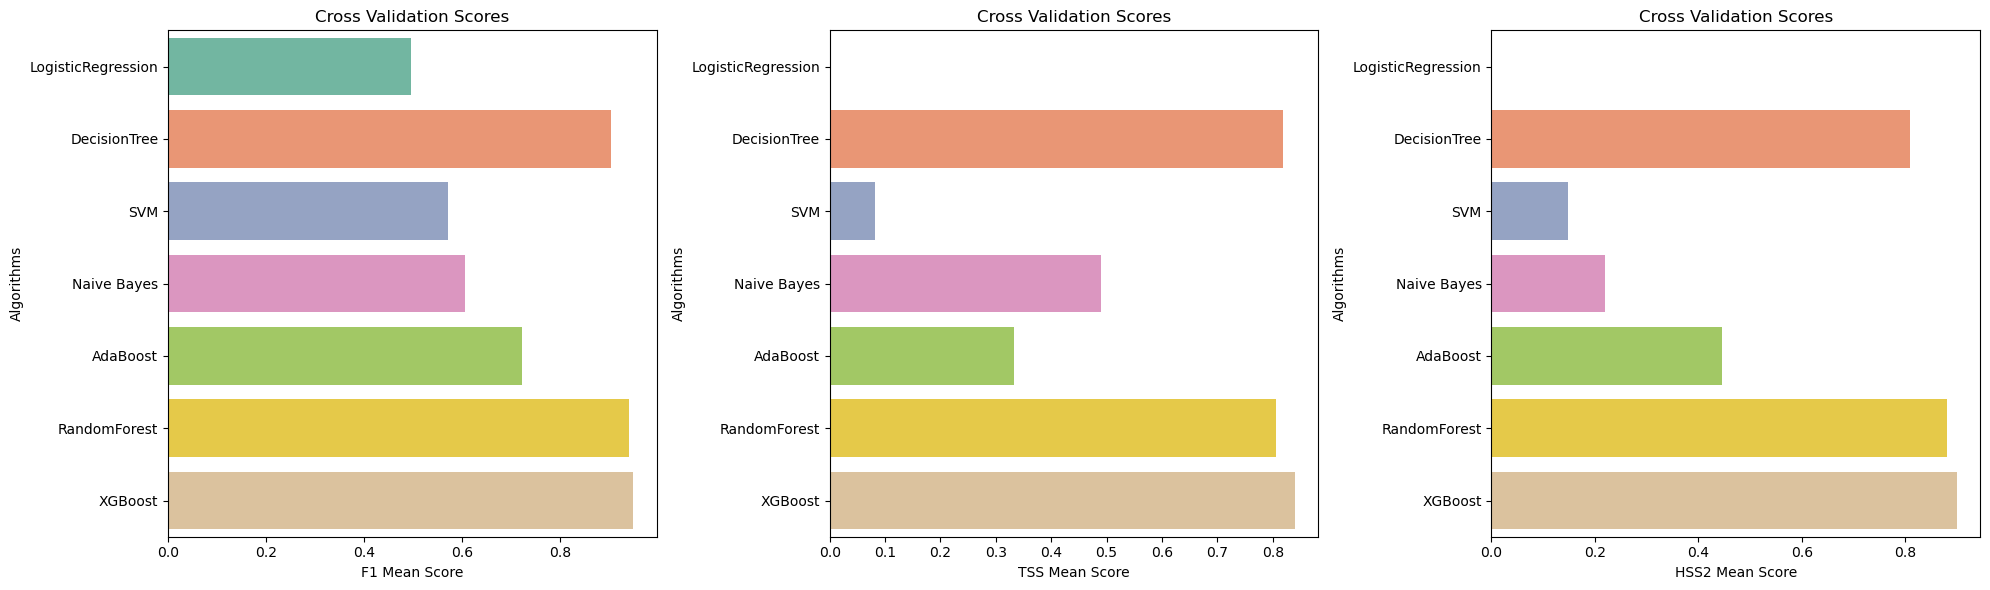

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.495696,0.000008,0.000000,0.000000,0.000000,0.000000
1,DecisionTree,0.904221,0.014821,0.817528,0.023797,0.808445,0.029641
2,SVM,0.571590,0.009713,0.082276,0.011463,0.148785,0.019084
3,Naive Bayes,0.605165,0.003611,0.490657,0.019121,0.219970,0.007214
4,AdaBoost,0.722834,0.011043,0.332309,0.017617,0.446549,0.022038
5,RandomForest,0.939887,0.007240,0.805649,0.022526,0.879793,0.014475
6,XGBoost,0.949689,0.012046,0.840140,0.033539,0.899388,0.024087


In [13]:
modelling_mulitple(x_train, y_train)

In [14]:
# baseline_modelling(x_train, y_train,'f1_macro')
# baseline_modelling(x_train, y_train,tss_scorer)
# baseline_modelling(x_train, y_train,hss2_scorer)

### Data Normalization

#### Min Max Scaler

In [15]:
x_train_MinMax = MinMaxScaler().fit_transform(x_train)

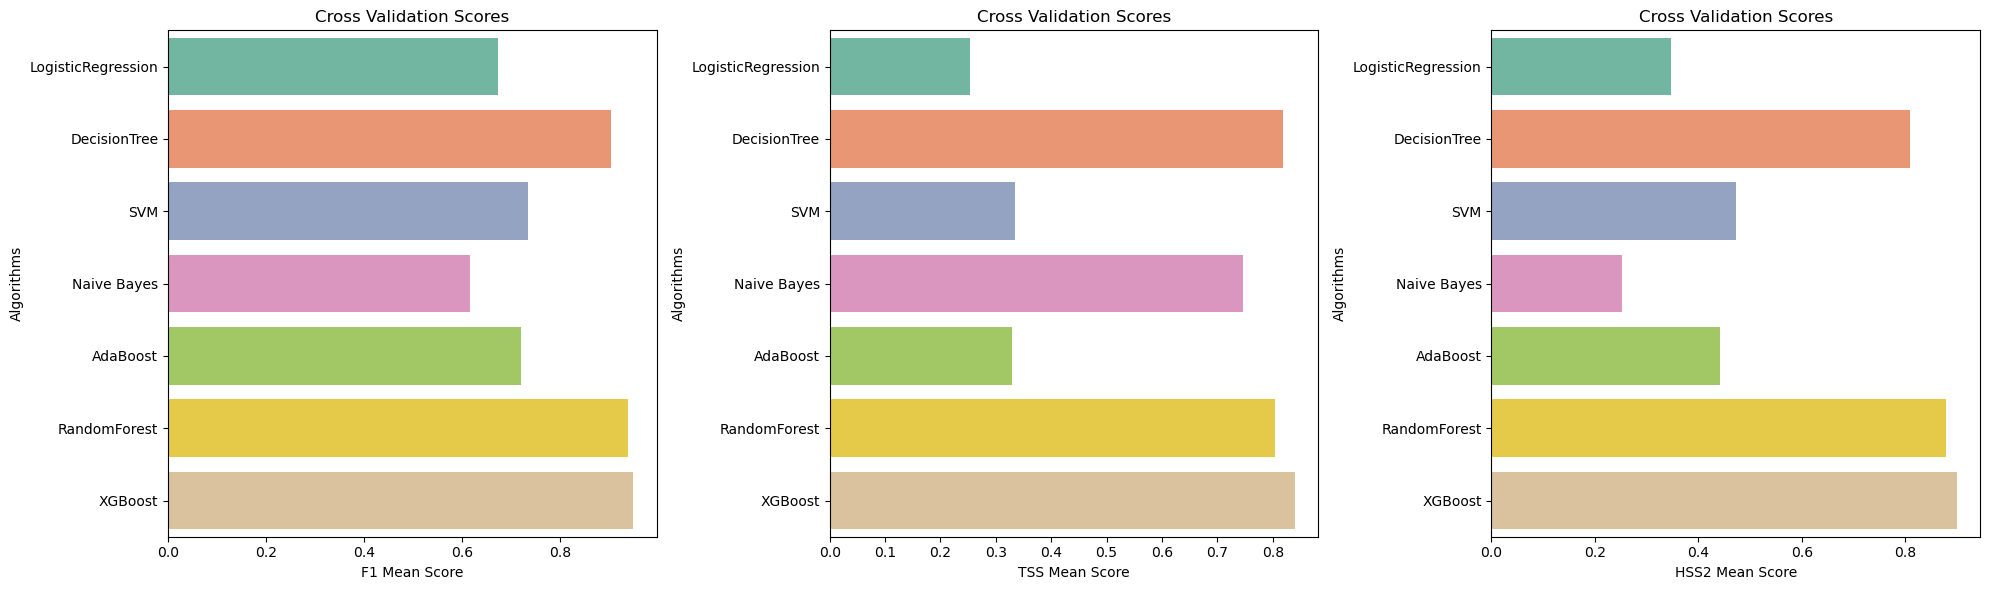

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.672821,0.015558,0.253532,0.026015,0.346824,0.030971
1,DecisionTree,0.904221,0.014821,0.817528,0.023797,0.808445,0.029641
2,SVM,0.735569,0.008592,0.335360,0.022385,0.472292,0.016951
3,Naive Bayes,0.617030,0.001585,0.746780,0.014403,0.251983,0.003084
4,AdaBoost,0.720484,0.012073,0.328708,0.017105,0.441856,0.024131
5,RandomForest,0.939603,0.008107,0.804764,0.023842,0.879225,0.016208
6,XGBoost,0.949689,0.012046,0.840140,0.033539,0.899388,0.024087


In [16]:
modelling_mulitple(x_train_MinMax, y_train)

#### Standard Scaler

In [17]:
x_train_Standard = StandardScaler().fit_transform(x_train)

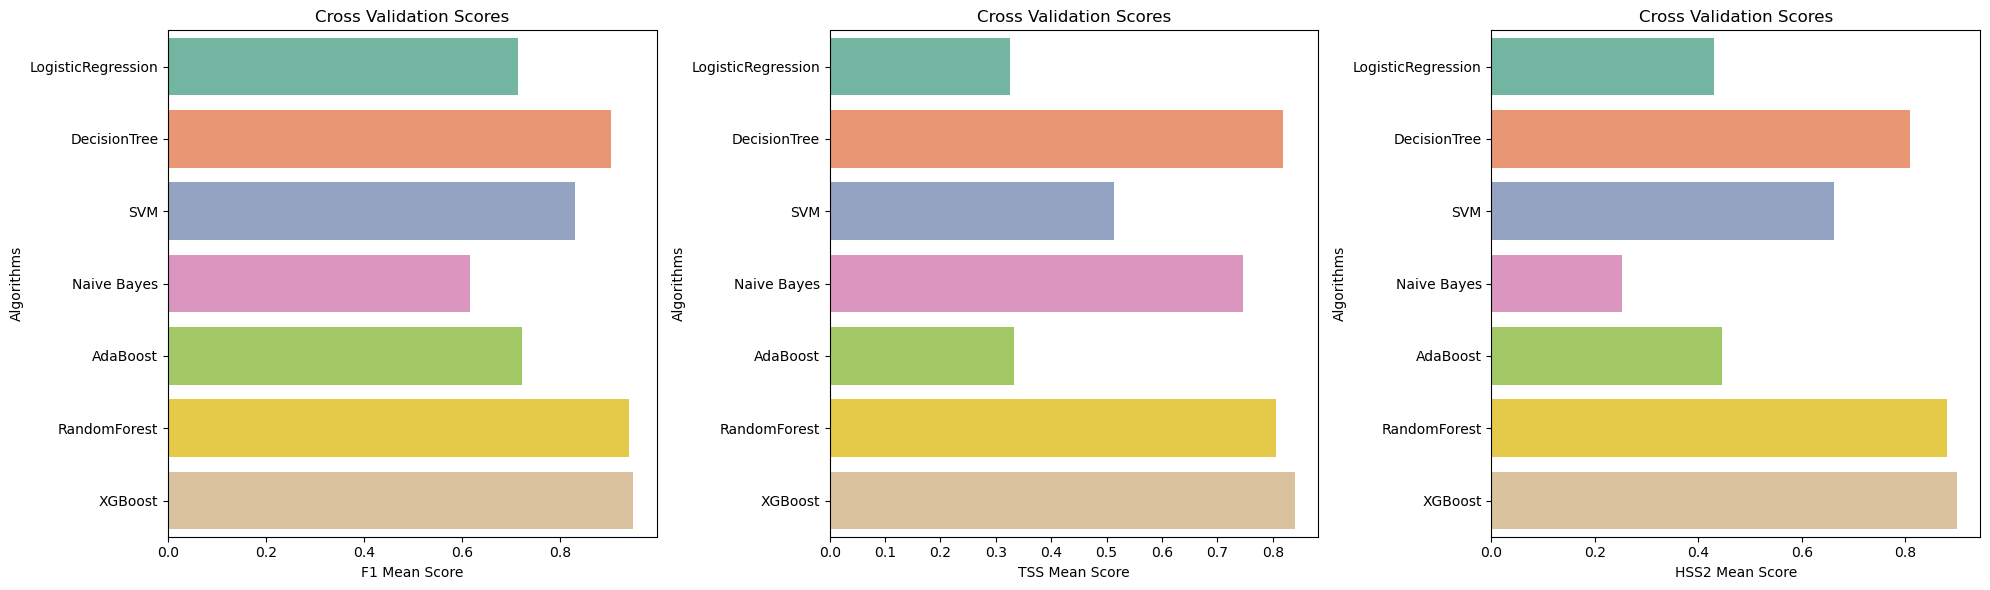

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.714755,0.005024,0.326403,0.009596,0.430302,0.010017
1,DecisionTree,0.904221,0.014821,0.817528,0.023797,0.808445,0.029641
2,SVM,0.830658,0.010026,0.514093,0.019400,0.661708,0.020008
3,Naive Bayes,0.617030,0.001585,0.746780,0.014403,0.251983,0.003084
4,AdaBoost,0.722834,0.011043,0.332309,0.017617,0.446549,0.022038
5,RandomForest,0.939887,0.007240,0.805649,0.022526,0.879793,0.014475
6,XGBoost,0.949689,0.012046,0.840140,0.033539,0.899388,0.024087


In [18]:
modelling_mulitple(x_train_Standard, y_train)

### Data Re- Sampling

#### Over Sampling

In [19]:
# Random Over Sampling
# Random Undersampling
# SMOTE
# SMOTE and Undersmapling
# Random Over Sampling and Undersmapling
# BorderLine
# ADASYN
# SVMSMOTE

#https://imbalanced-learn.org/stable/over_sampling.html

###### Random Over Sampling

[(0, 65013), (1, 65013)]


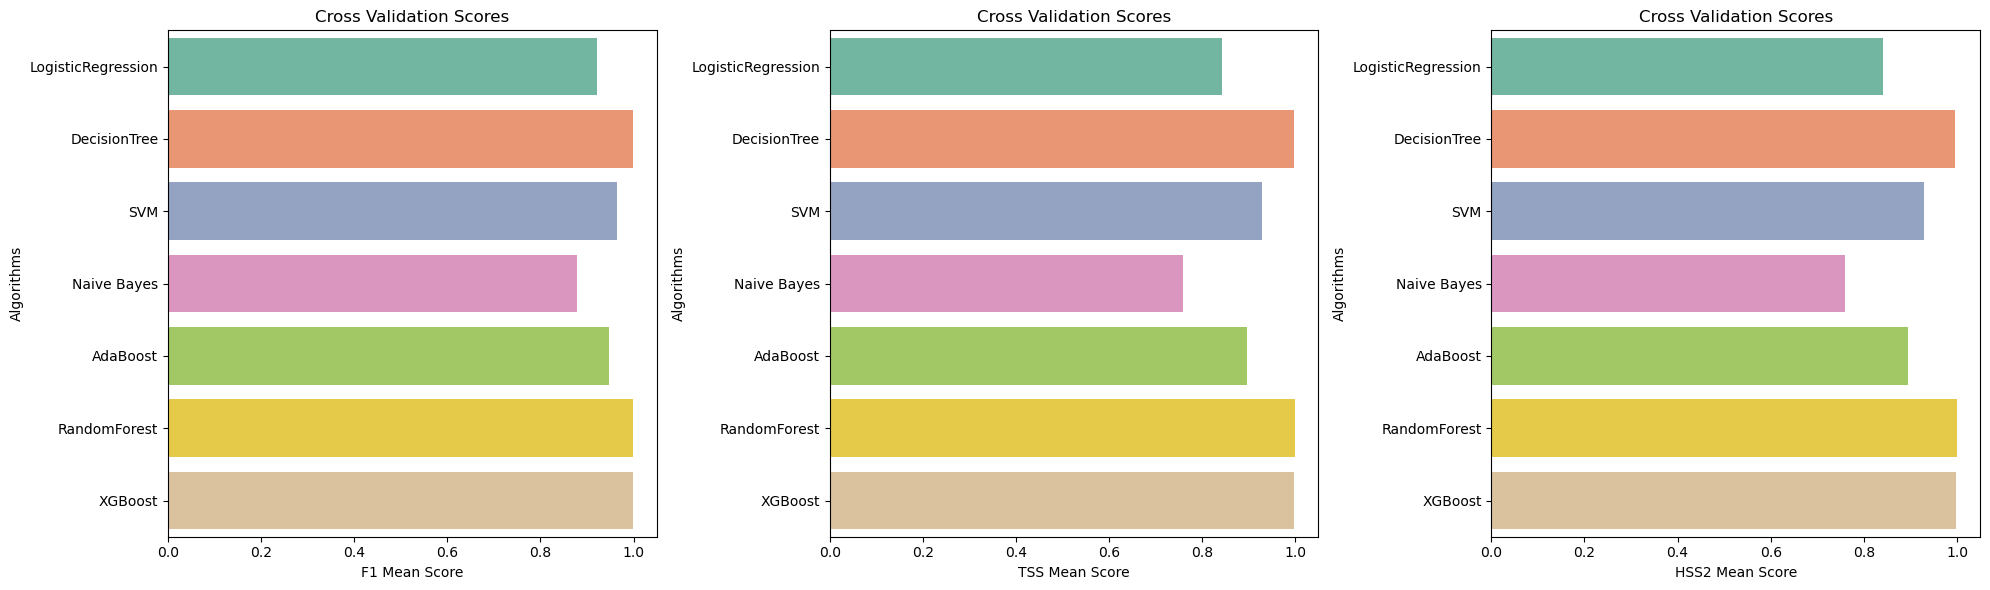

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.920874,0.000504,0.841755,0.001005,0.841755,0.001005
1,DecisionTree,0.998008,0.000520,0.996016,0.001039,0.996016,0.001039
2,SVM,0.964125,0.001668,0.928307,0.003330,0.928307,0.003330
3,Naive Bayes,0.879452,0.001534,0.759356,0.003045,0.759356,0.003046
4,AdaBoost,0.947753,0.001988,0.895698,0.003965,0.895698,0.003966
5,RandomForest,0.999677,0.000155,0.999354,0.000310,0.999354,0.000310
6,XGBoost,0.998985,0.000180,0.997970,0.000359,0.997970,0.000359


In [20]:
ros = RandomOverSampler(random_state = random_state)
x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_samp).items()))
modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### SMOTE

[(0, 65013), (1, 65013)]


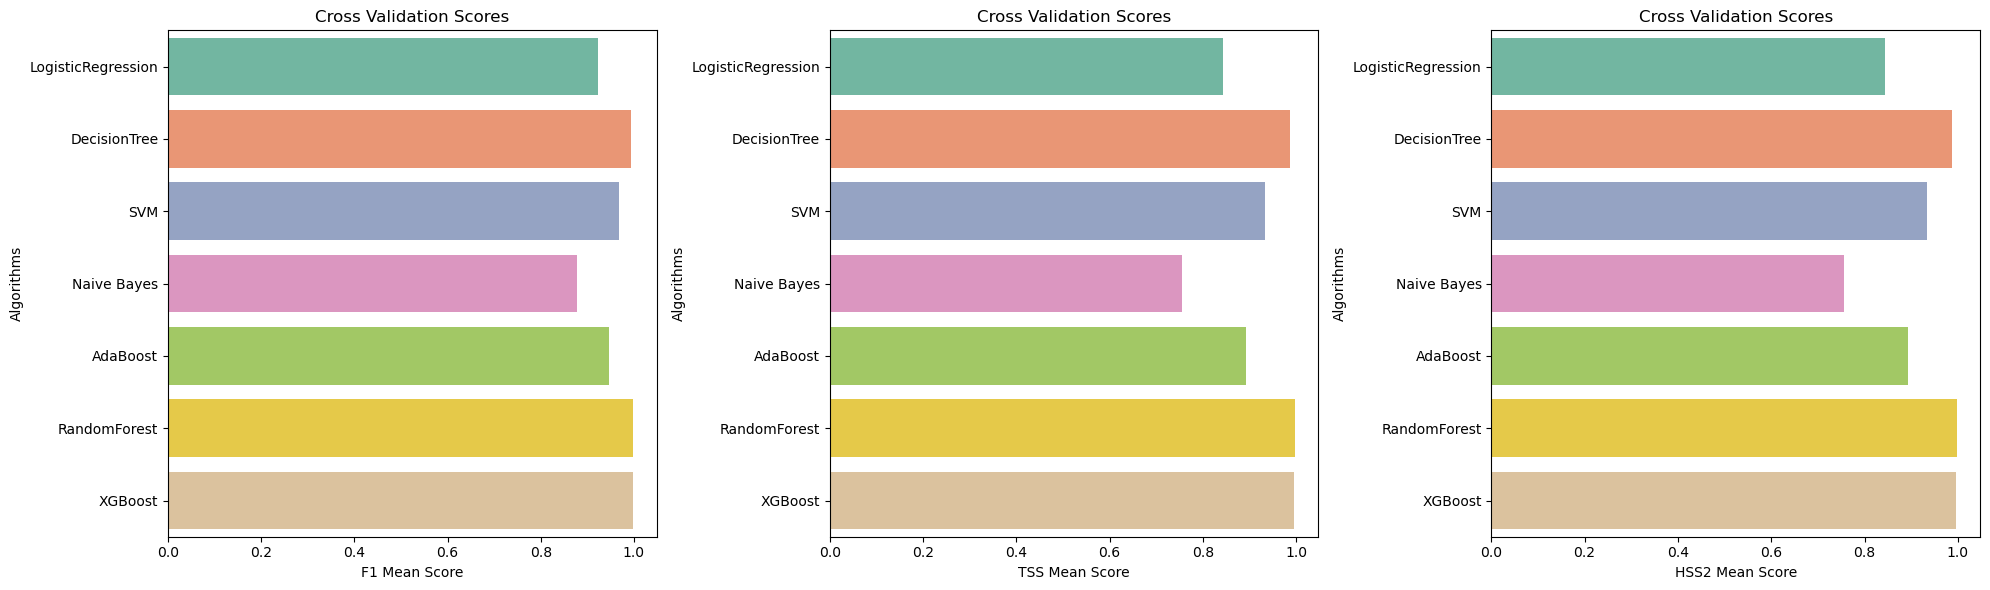

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.921796,0.001731,0.843600,0.003460,0.843601,0.003460
1,DecisionTree,0.993332,0.000571,0.986664,0.001142,0.986664,0.001143
2,SVM,0.966929,0.000802,0.933890,0.001599,0.933890,0.001599
3,Naive Bayes,0.877288,0.001726,0.755080,0.003430,0.755080,0.003429
4,AdaBoost,0.946093,0.000925,0.892329,0.001839,0.892329,0.001839
5,RandomForest,0.998823,0.000251,0.997647,0.000502,0.997647,0.000502
6,XGBoost,0.997808,0.000388,0.995616,0.000777,0.995616,0.000777


In [21]:
ros = SMOTE(random_state = random_state)
x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_samp).items()))
modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### ADASYN

[(0, 65013), (1, 65059)]


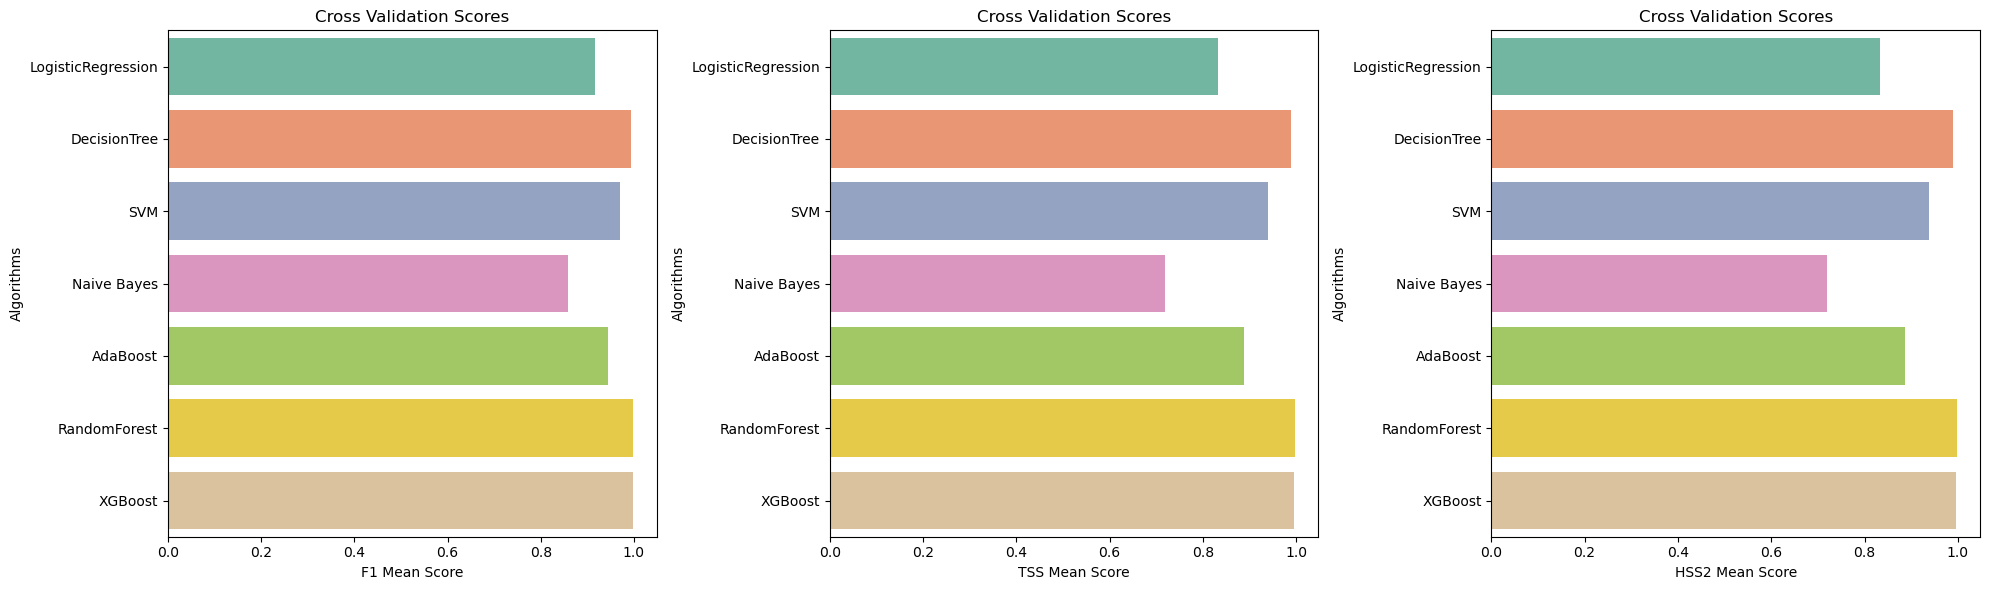

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.916038,0.001521,0.832080,0.003040,0.832078,0.003041
1,DecisionTree,0.994488,0.000366,0.988974,0.000732,0.988975,0.000732
2,SVM,0.969405,0.000727,0.938831,0.001452,0.938848,0.001451
3,Naive Bayes,0.858922,0.002760,0.718560,0.005461,0.718535,0.005462
4,AdaBoost,0.943582,0.002670,0.887326,0.005332,0.887351,0.005333
5,RandomForest,0.998816,0.000240,0.997631,0.000480,0.997632,0.000480
6,XGBoost,0.997786,0.000416,0.995570,0.000832,0.995572,0.000832


In [22]:
ros = ADASYN(random_state = random_state)
x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_samp).items()))
modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### BorderlineSMOTE

[(0, 65013), (1, 65013)]


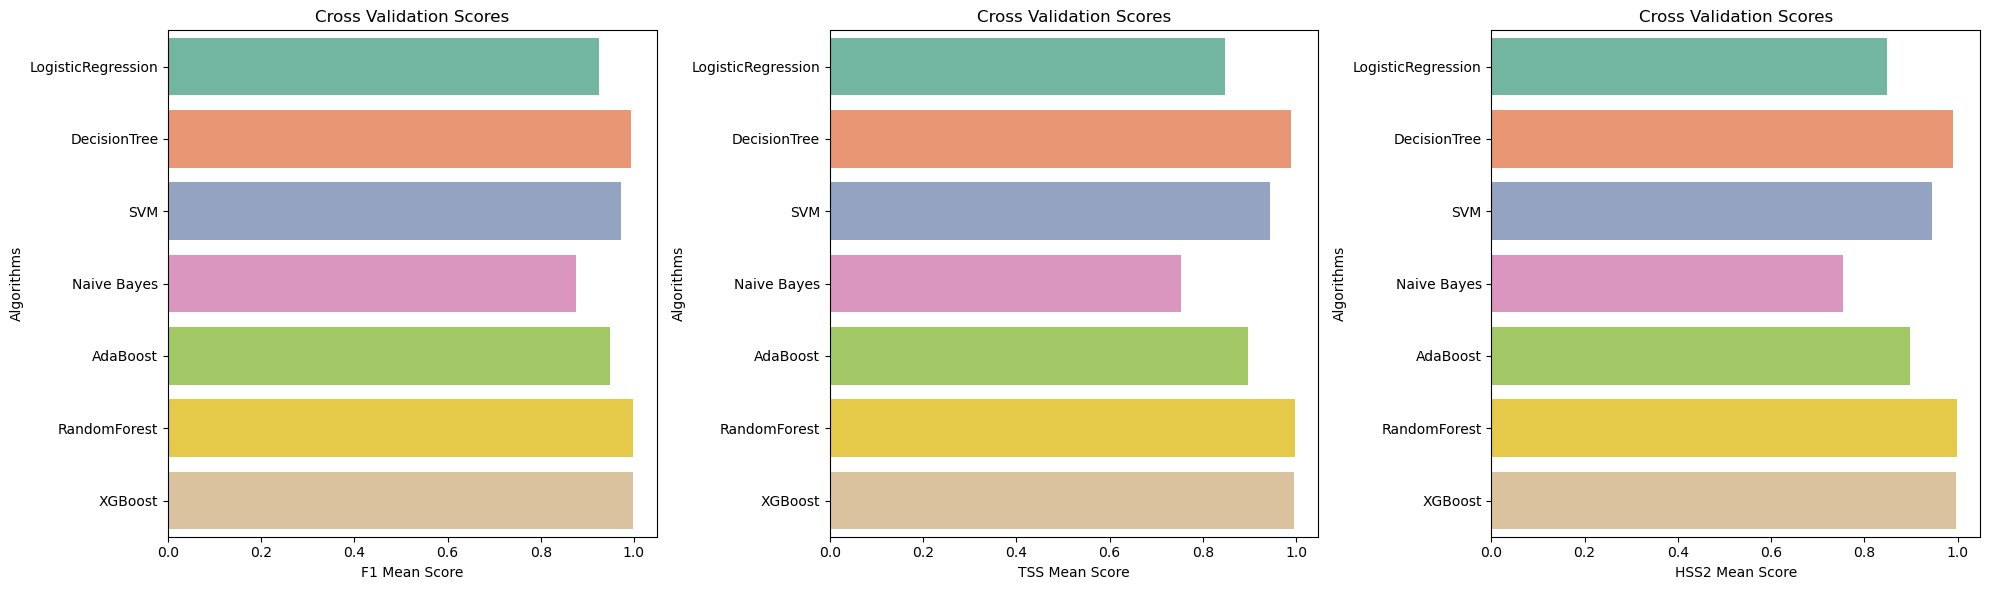

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.924154,0.001298,0.848307,0.002596,0.848307,0.002596
1,DecisionTree,0.994378,0.000389,0.988756,0.000779,0.988756,0.000779
2,SVM,0.971896,0.000843,0.943827,0.001683,0.943827,0.001682
3,Naive Bayes,0.876590,0.002154,0.753511,0.004287,0.753511,0.004288
4,AdaBoost,0.948306,0.001400,0.896759,0.002793,0.896759,0.002793
5,RandomForest,0.998877,0.000297,0.997754,0.000595,0.997754,0.000595
6,XGBoost,0.998023,0.000157,0.996047,0.000314,0.996047,0.000314


In [23]:
ros = BorderlineSMOTE(random_state = random_state)
x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_samp).items()))
modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### SVMSMOTE

[(0, 65013), (1, 65013)]


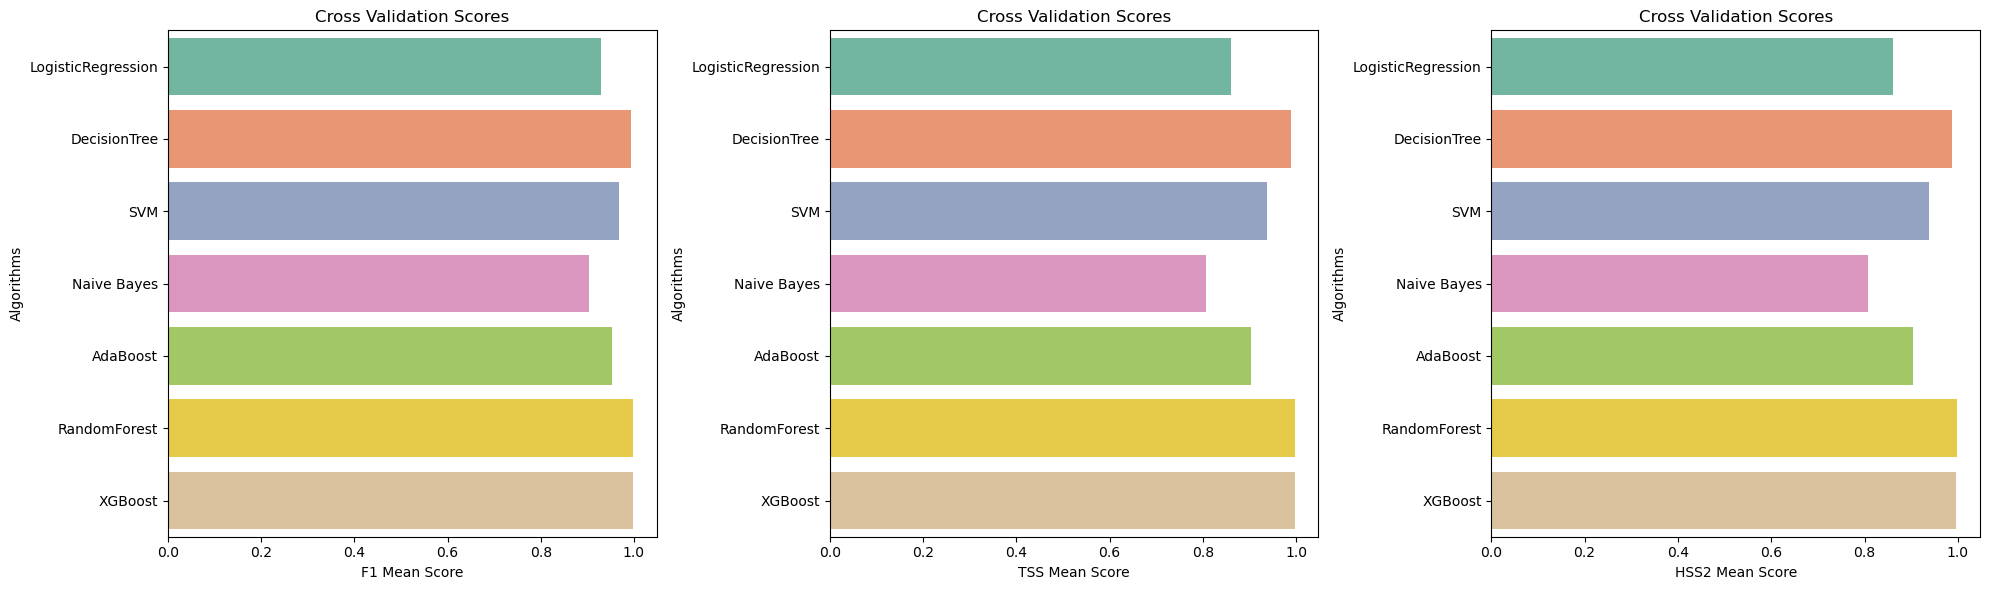

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.930245,0.001283,0.860505,0.002563,0.860505,0.002563
1,DecisionTree,0.994147,0.000609,0.988295,0.001218,0.988295,0.001218
2,SVM,0.968899,0.001168,0.937812,0.002334,0.937812,0.002334
3,Naive Bayes,0.903207,0.002389,0.806531,0.004756,0.806531,0.004757
4,AdaBoost,0.952000,0.001944,0.904081,0.003885,0.904081,0.003886
5,RandomForest,0.998839,0.000174,0.997677,0.000349,0.997677,0.000349
6,XGBoost,0.998239,0.000284,0.996478,0.000568,0.996478,0.000568


In [24]:
ros = SVMSMOTE(random_state = random_state)
x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_samp).items()))
modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### SMOTEN

[(0, 65013), (1, 65013)]


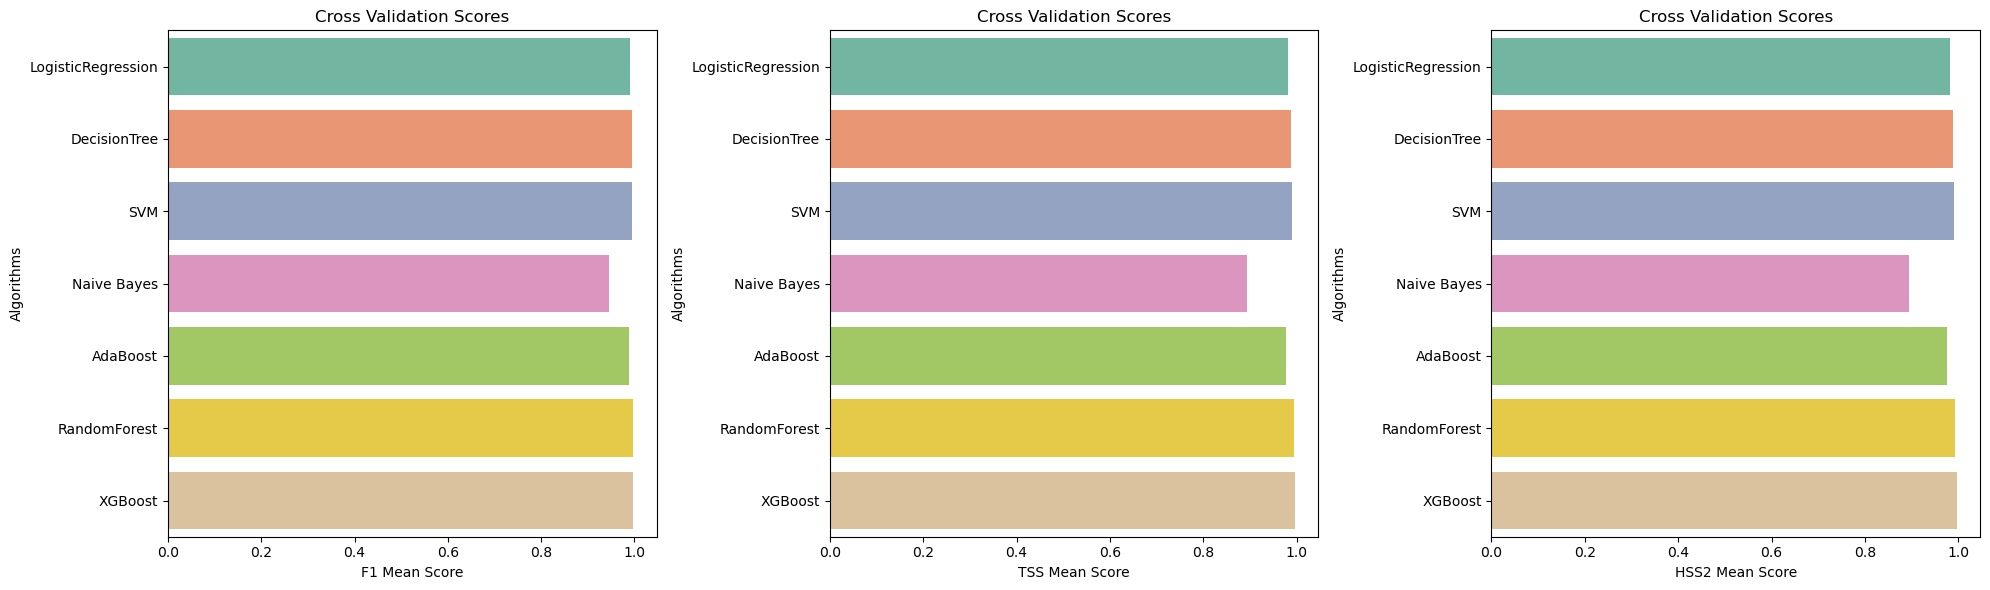

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.990740,0.000382,0.981481,0.000764,0.981481,0.000764
1,DecisionTree,0.994332,0.000237,0.988664,0.000473,0.988664,0.000473
2,SVM,0.995401,0.000280,0.990802,0.000560,0.990802,0.000560
3,Naive Bayes,0.946760,0.000795,0.893529,0.001589,0.893529,0.001589
4,AdaBoost,0.988133,0.000459,0.976266,0.000918,0.976266,0.000919
5,RandomForest,0.996816,0.000283,0.993632,0.000566,0.993632,0.000566
6,XGBoost,0.998223,0.000253,0.996447,0.000506,0.996447,0.000506


In [25]:
ros = SMOTEN(random_state = random_state)
x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_samp).items()))
modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### KMeansSMOTE

In [26]:
# ros = KMeansSMOTE(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(x_train_samp, y_train_samp)

#### Undersampling

###### ClusterCentroids

[(0, 1129), (1, 1129)]


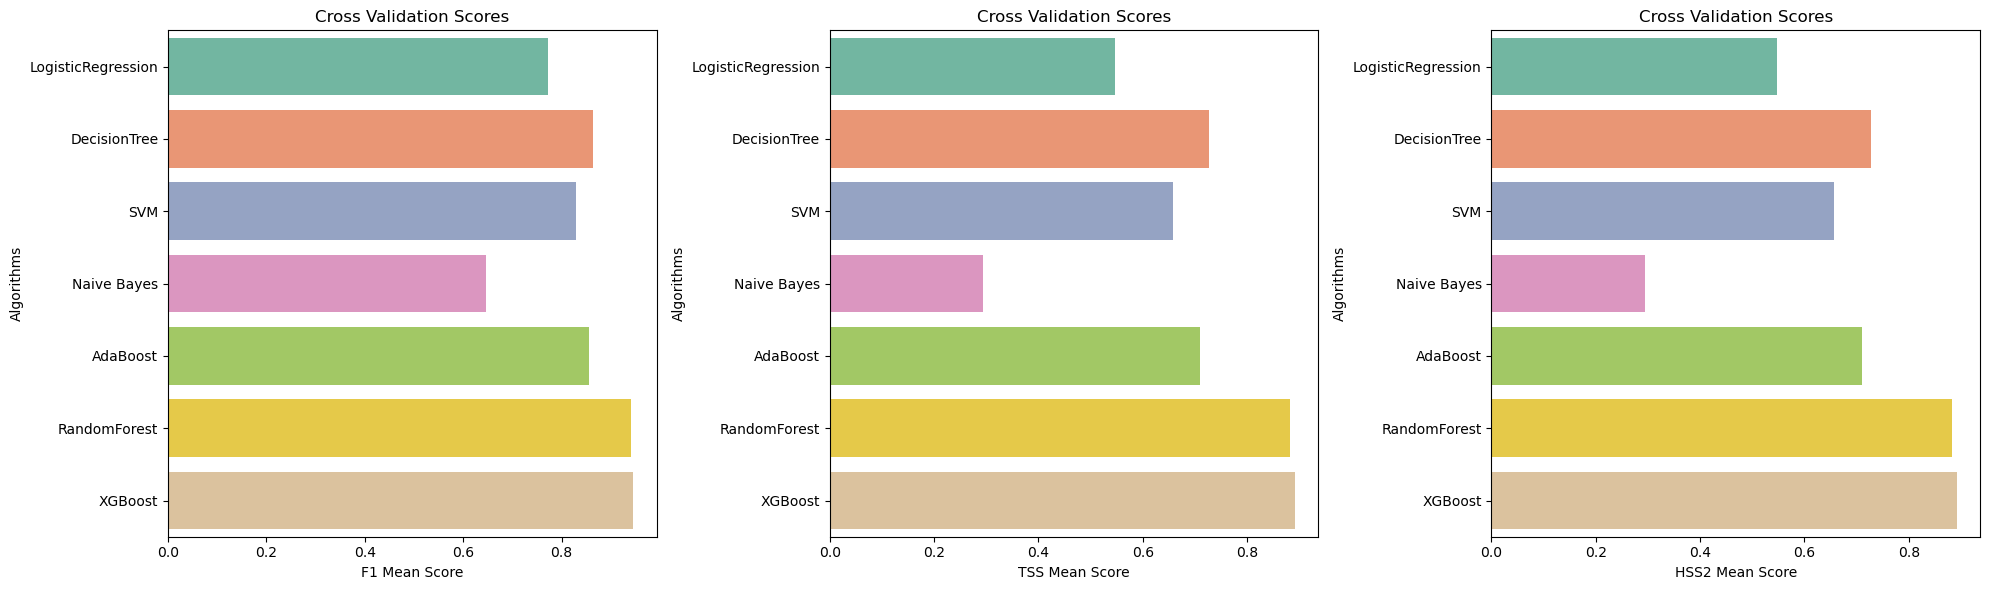

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.772496,0.005993,0.547359,0.011412,0.547368,0.011388
1,DecisionTree,0.863544,0.012599,0.727166,0.025208,0.727170,0.025203
2,SVM,0.828268,0.015221,0.657176,0.030291,0.657190,0.030227
3,Naive Bayes,0.646601,0.013630,0.294033,0.027072,0.294052,0.027091
4,AdaBoost,0.854695,0.015627,0.709455,0.031239,0.709455,0.031224
5,RandomForest,0.941510,0.008747,0.883076,0.017468,0.883072,0.017464
6,XGBoost,0.945933,0.010645,0.891941,0.021251,0.891938,0.021252


In [27]:
ros = ClusterCentroids(random_state = random_state)
x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_samp).items()))
modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### RandomUnderSampler

[(0, 1129), (1, 1129)]


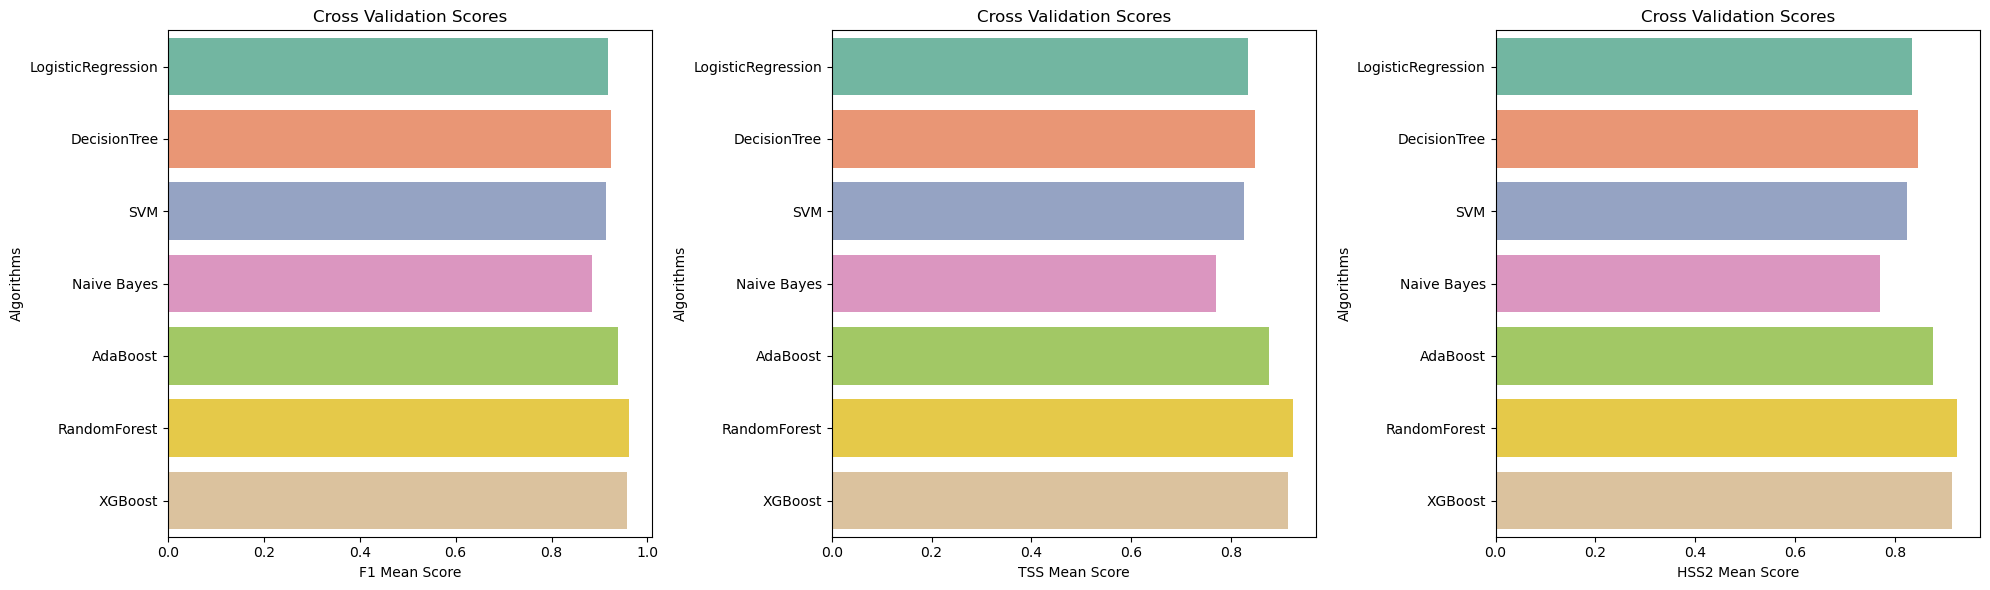

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.917172,0.018303,0.834356,0.036611,0.834360,0.036596
1,DecisionTree,0.923812,0.013480,0.847689,0.027017,0.847675,0.026984
2,SVM,0.912714,0.017287,0.825522,0.034561,0.825514,0.034572
3,Naive Bayes,0.885057,0.022632,0.770572,0.045107,0.770571,0.045044
4,AdaBoost,0.937953,0.007439,0.876012,0.014816,0.875995,0.014848
5,RandomForest,0.962331,0.008304,0.924739,0.016531,0.924715,0.016569
6,XGBoost,0.957453,0.008678,0.914985,0.017328,0.914971,0.017338


In [28]:
ros = RandomUnderSampler(random_state = random_state)
x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_samp).items()))
modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

###### NearMiss

[(0, 1129), (1, 1129)]


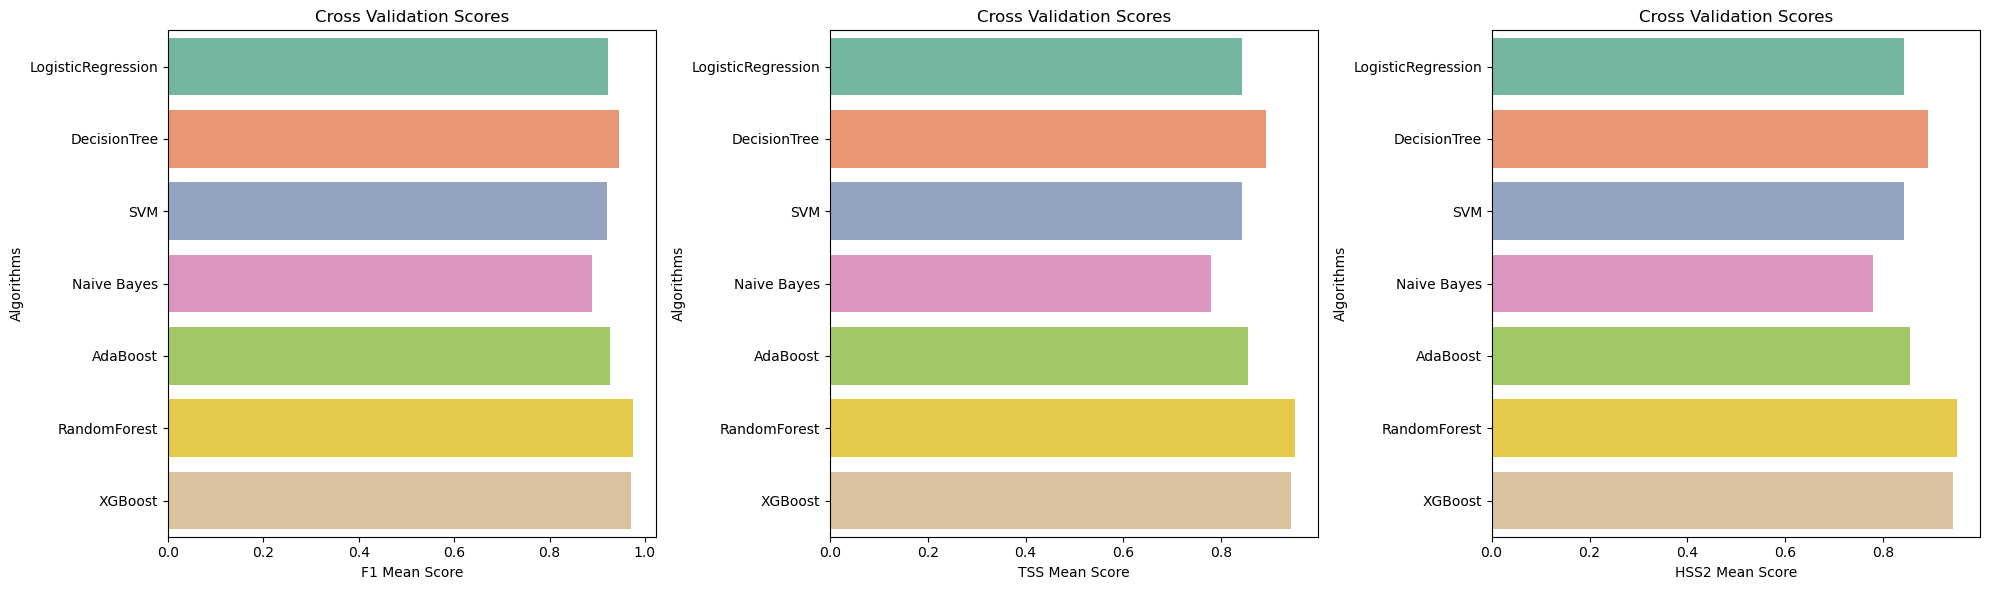

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.921539,0.019059,0.843233,0.038094,0.843237,0.038077
1,DecisionTree,0.945960,0.013925,0.891917,0.027855,0.891926,0.027850
2,SVM,0.921104,0.019924,0.842344,0.039770,0.842354,0.039771
3,Naive Bayes,0.888773,0.014950,0.778545,0.029622,0.778555,0.029541
4,AdaBoost,0.927359,0.017900,0.854726,0.035803,0.854731,0.035802
5,RandomForest,0.975192,0.008804,0.950399,0.017584,0.950390,0.017602
6,XGBoost,0.971652,0.007847,0.943324,0.015687,0.943311,0.015692


In [29]:
ros = NearMiss(version=1)
x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_samp).items()))
modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

#### Combined Over & Undersampling

###### SMOTETomek

[(0, 64997), (1, 64997)]


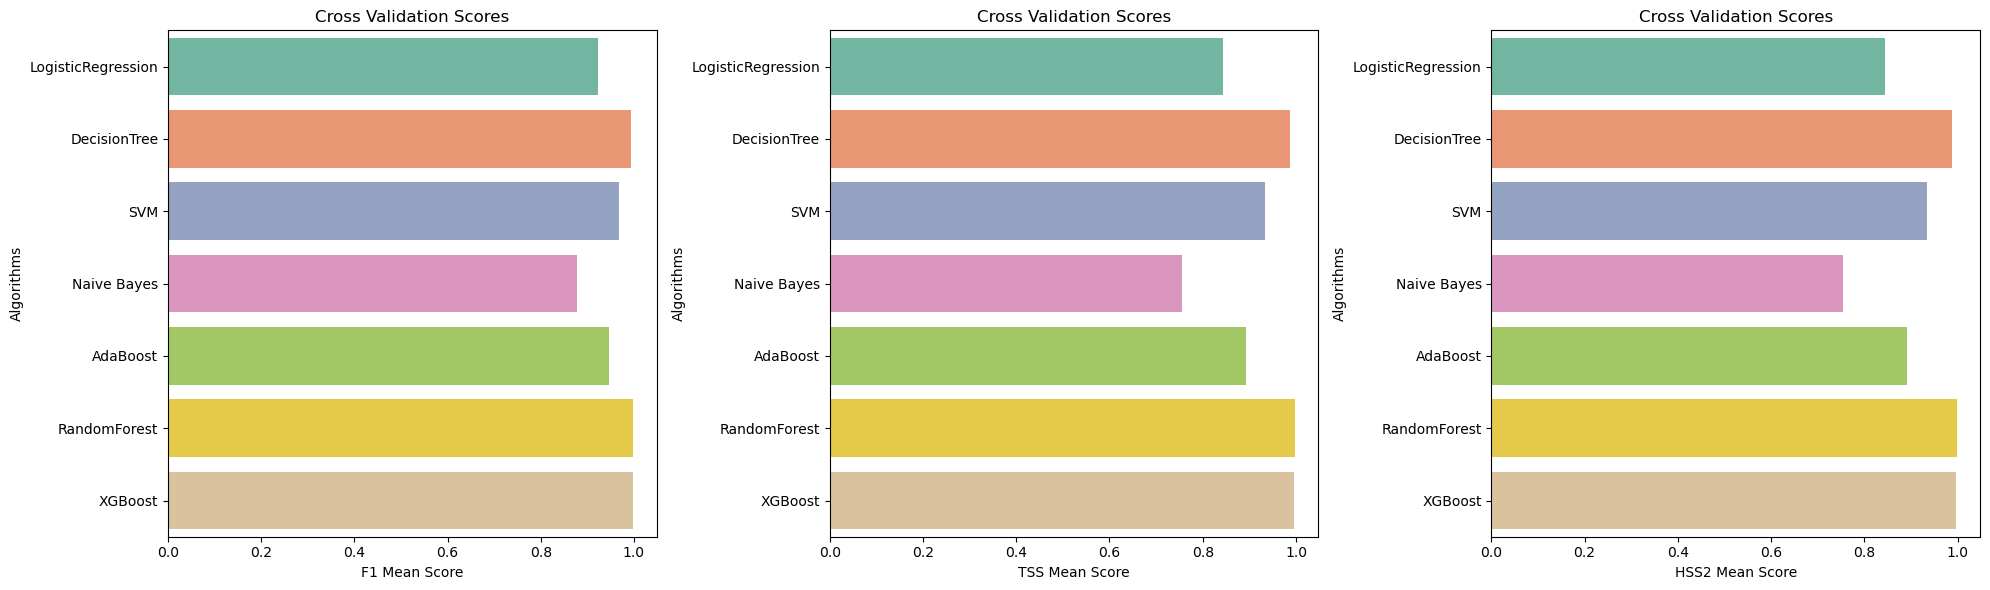

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.921939,0.001029,0.843885,0.002054,0.843885,0.002054
1,DecisionTree,0.993684,0.000536,0.987369,0.001072,0.987369,0.001072
2,SVM,0.967221,0.000520,0.934474,0.001037,0.934474,0.001039
3,Naive Bayes,0.877329,0.001772,0.755158,0.003531,0.755158,0.003529
4,AdaBoost,0.946030,0.002367,0.892195,0.004733,0.892195,0.004733
5,RandomForest,0.998992,0.000160,0.997985,0.000320,0.997985,0.000321
6,XGBoost,0.998115,0.000389,0.996231,0.000778,0.996231,0.000778


In [30]:
ros = SMOTETomek(random_state = random_state)
x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_samp).items()))
modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

 ###### SMOTEENN

[(0, 62901), (1, 64835)]


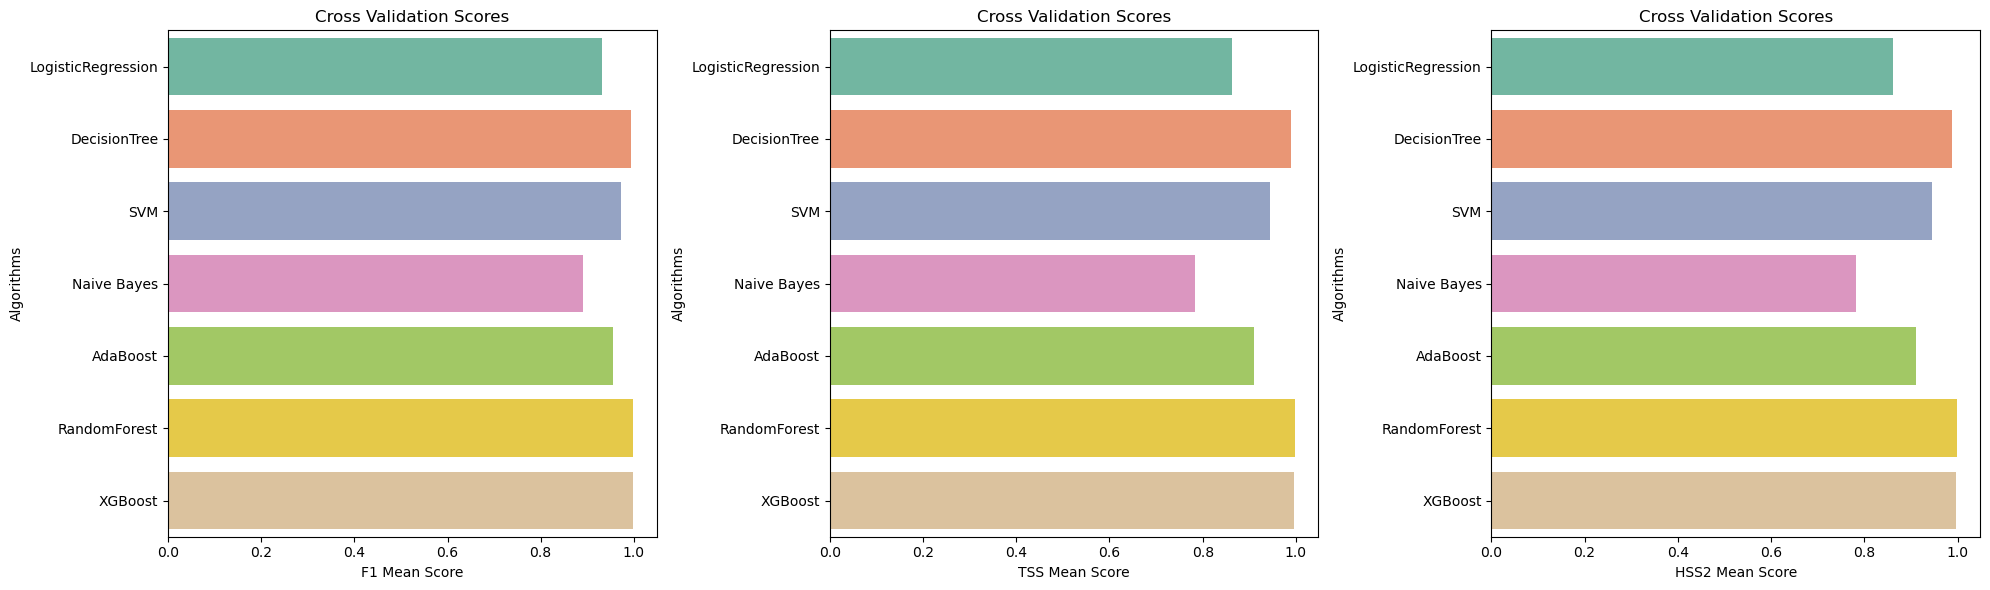

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.930937,0.000532,0.862034,0.001065,0.861880,0.001064
1,DecisionTree,0.994463,0.000780,0.988850,0.001571,0.988927,0.001560
2,SVM,0.972040,0.001157,0.943526,0.002337,0.944103,0.002311
3,Naive Bayes,0.890918,0.001329,0.783136,0.002639,0.782187,0.002645
4,AdaBoost,0.955439,0.001614,0.910070,0.003232,0.910973,0.003222
5,RandomForest,0.999045,0.000185,0.998066,0.000372,0.998089,0.000369
6,XGBoost,0.998316,0.000113,0.996584,0.000232,0.996633,0.000227


In [31]:
ros = SMOTEENN(random_state = random_state)
x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_samp).items()))
modelling_mulitple(StandardScaler().fit_transform(x_train_samp), y_train_samp)

#### Feature Selection

###### Feed Forward (Support Vector Machine) (F1 Score)


In [32]:
y_train.value_counts()

0    65013
1     1129
Name: label, dtype: int64

In [33]:
def classifier(x_train, y_train,scoring):
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    classifiers = GaussianNB()
    scores = cross_val_score(classifiers, MinMaxScaler().fit_transform(x_train), y_train, scoring=scoring, cv=cv)
    
    return scores.mean()

In [34]:
def feed_forward(unprocessed_cols,current_bestcols,scoring):
    
    results = [classifier(StandardScaler().fit_transform(x_train[current_bestcols + [x]]), y_train,scoring) for x in unprocessed_cols]
    current_bestcols = current_bestcols + [unprocessed_cols[results.index(max(results))]]
    bestcols.append((max(results), current_bestcols))
    unprocessed_cols.pop(results.index(max(results)))
    if len(unprocessed_cols) > 0:
        print(f"{len(unprocessed_cols)} columns left to process")
        feed_forward(unprocessed_cols,current_bestcols,scoring)
    else:
        return bestcols

In [35]:
plt.rcParams.update(plt.rcParamsDefault)

39 columns left to process
38 columns left to process
37 columns left to process
36 columns left to process
35 columns left to process
34 columns left to process
33 columns left to process
32 columns left to process
31 columns left to process
30 columns left to process
29 columns left to process
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 column

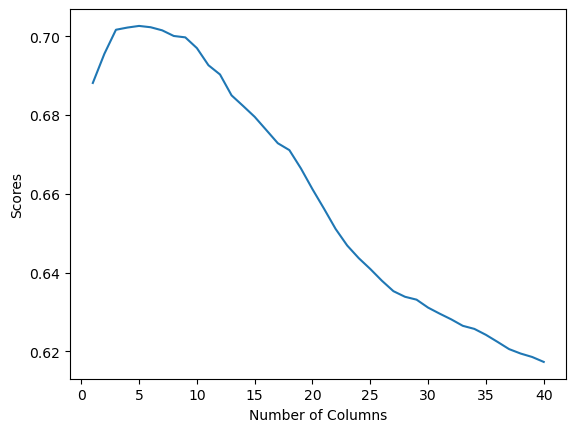

In [36]:
bestcols = []
cols = x_train.columns.tolist()
feed_forward(cols,bestcols,scoring='f1_macro')
sns.lineplot(x=[len(x[1]) for x in bestcols], y=[x[0] for x in bestcols], palette='Set2')
plt.xlabel('Number of Columns')
plt.ylabel('Scores')
plt.show()

39 columns left to process
38 columns left to process
37 columns left to process
36 columns left to process
35 columns left to process
34 columns left to process
33 columns left to process
32 columns left to process
31 columns left to process
30 columns left to process
29 columns left to process
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 column

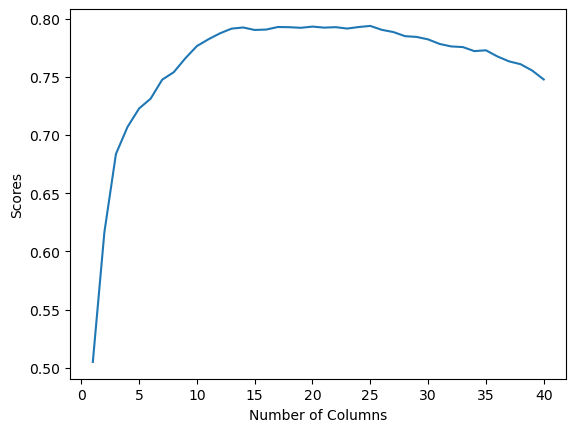

In [37]:
bestcols = []
cols = x_train.columns.tolist()
feed_forward(cols,bestcols,scoring=tss_scorer)
sns.lineplot(x=[len(x[1]) for x in bestcols], y=[x[0] for x in bestcols], palette='Set2')
plt.xlabel('Number of Columns')
plt.ylabel('Scores')
plt.show()

39 columns left to process
38 columns left to process
37 columns left to process
36 columns left to process
35 columns left to process
34 columns left to process
33 columns left to process
32 columns left to process
31 columns left to process
30 columns left to process
29 columns left to process
28 columns left to process
27 columns left to process
26 columns left to process
25 columns left to process
24 columns left to process
23 columns left to process
22 columns left to process
21 columns left to process
20 columns left to process
19 columns left to process
18 columns left to process
17 columns left to process
16 columns left to process
15 columns left to process
14 columns left to process
13 columns left to process
12 columns left to process
11 columns left to process
10 columns left to process
9 columns left to process
8 columns left to process
7 columns left to process
6 columns left to process
5 columns left to process
4 columns left to process
3 columns left to process
2 column

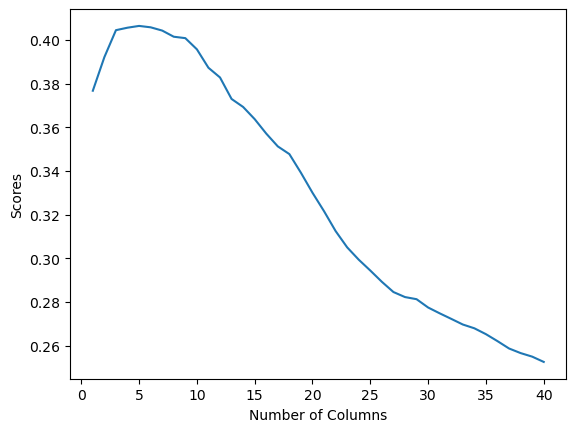

In [38]:
bestcols = []
cols = x_train.columns.tolist()
feed_forward(cols,bestcols,scoring=hss2_scorer)
sns.lineplot(x=[len(x[1]) for x in bestcols], y=[x[0] for x in bestcols], palette='Set2')
plt.xlabel('Number of Columns')
plt.ylabel('Scores')
plt.show()

#### Noise Reduction

###### DBSCAN

In [39]:
# # Use random Undersampling to stabilize the data
# ros = RandomUnderSampler(random_state = random_state)
# x_train_samp, y_train_samp = ros.fit_resample(x_train, y_train)
# print(sorted(Counter(y_train_samp).items()))
# modelling_mulitple(MinMaxScaler().fit_transform(x_train_samp), y_train_samp)

In [50]:
# Sampled data
data = StandardScaler().fit_transform(x_train_samp[bestcols[5][1]])

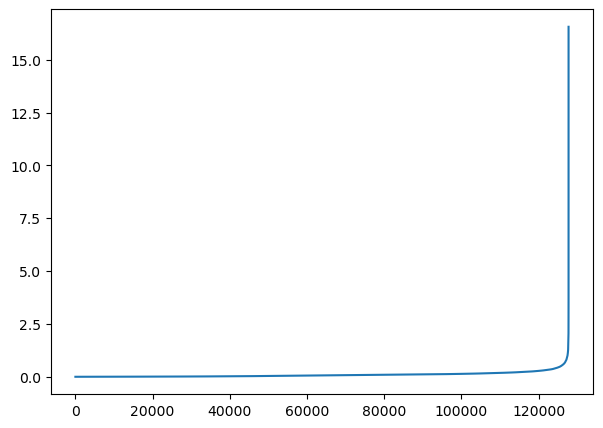

In [51]:
# Optimal Eps
#https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(data)
distances, indices = neighbors_fit.kneighbors(data)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = [7.00, 5.00]

plt.plot(distances)
plt.show()

In [52]:
db = DBSCAN(eps = 0.25, min_samples = 5).fit(data) 
labels = db.labels_

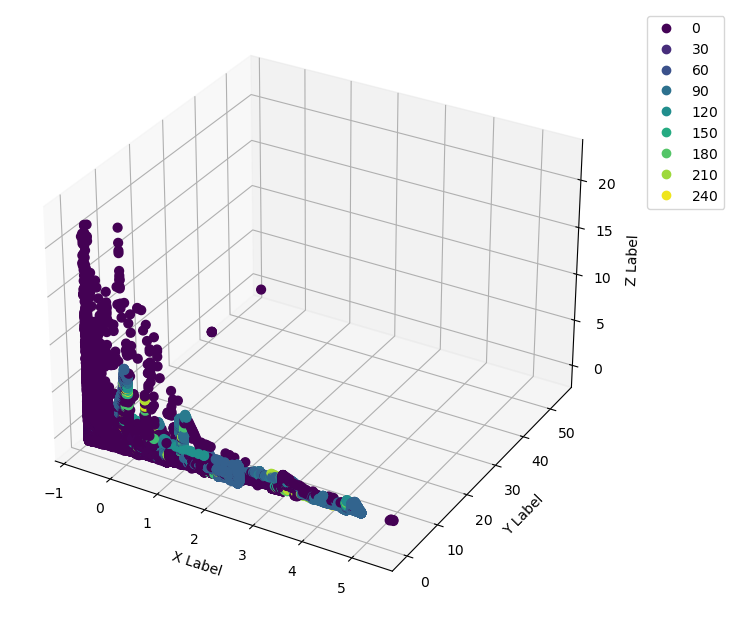

In [53]:
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter([x[0] for x in data], [x[1] for x in data], [x[2] for x in data], s=40, c=labels, marker='o', alpha=1)
# sc = ax.scatter(data[data.columns[0]], data[data.columns[1]], data[data.columns[2]], s=40, c=labels, marker='o', alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.show()

In [54]:
idxs = [idx for idx, value in enumerate(labels.tolist()) if value == -1]
to_check = x_train_samp.index.tolist()
noise = [value for idx,value in enumerate(to_check) if idx in idxs]

In [55]:
# modelling_mulitple(x_train_samp[x_train_samp.index.isin(noise)], y_train_samp[y_train_samp.index.isin(noise)])

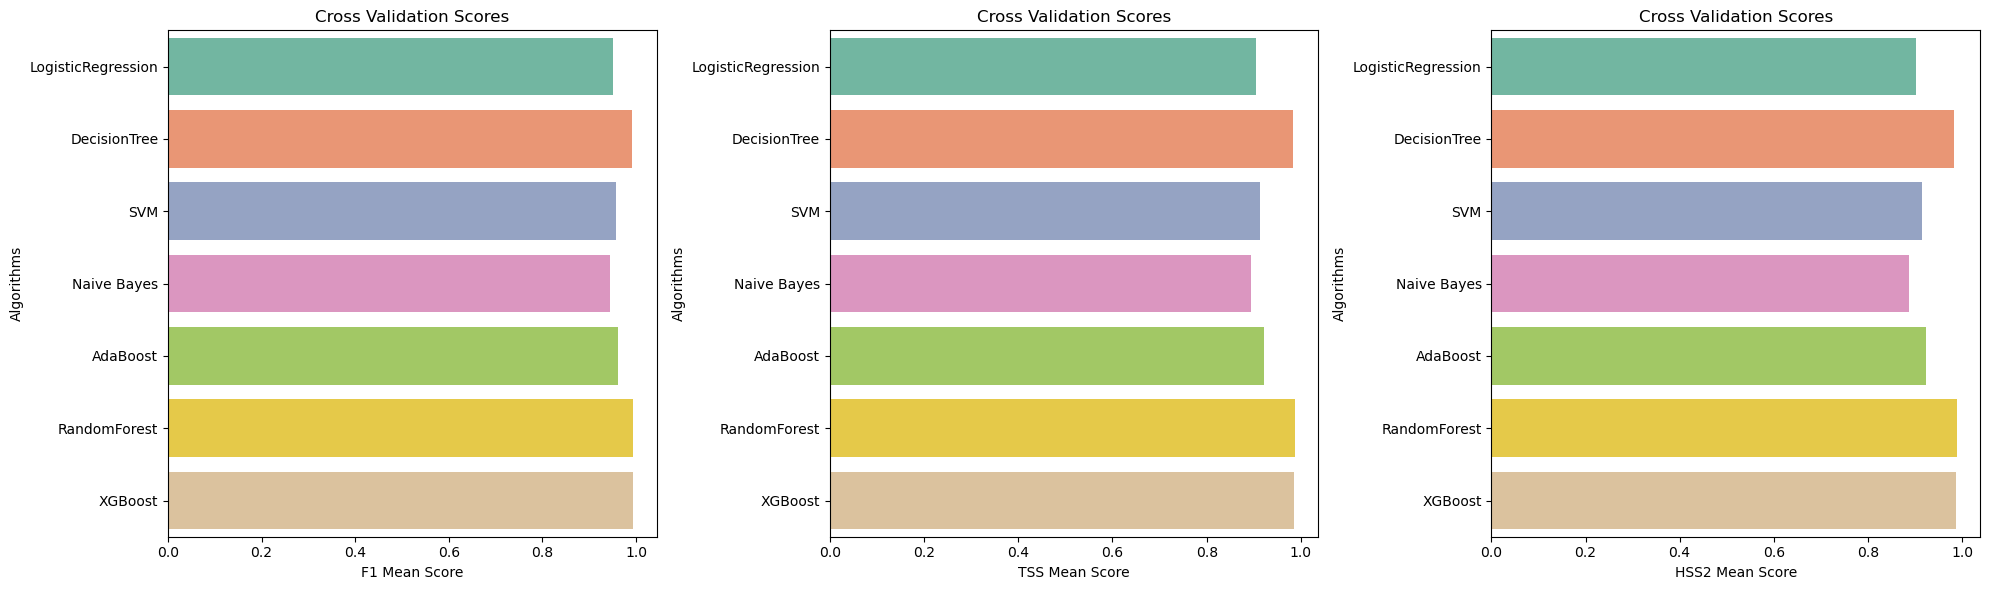

,Algorithms,F1 Mean Score,F1 std,TSS Mean Score,TSS std,HSS2 Mean Score,HSS2 std
0,LogisticRegression,0.950931,0.001108,0.904780,0.002254,0.901880,0.002216
1,DecisionTree,0.991803,0.000613,0.983114,0.001278,0.983607,0.001226
2,SVM,0.957381,0.001069,0.914128,0.002158,0.914764,0.002139
3,Naive Bayes,0.944092,0.001522,0.893529,0.002994,0.888251,0.003039
4,AdaBoost,0.961881,0.001180,0.920805,0.002458,0.923776,0.002360
5,RandomForest,0.994325,0.000300,0.987524,0.000648,0.988650,0.000601
6,XGBoost,0.993271,0.000333,0.985211,0.000716,0.986543,0.000666


In [56]:
# 0.917269	0.004286	0.834551	0.008577	0.834553	0.008574
modelling_mulitple(MinMaxScaler().fit_transform(x_train_samp[~x_train_samp.index.isin(noise)][bestcols[5][1]]), y_train_samp[~y_train_samp.index.isin(noise)])